

Курсовая
-------------
Минимизация погрешности восстановления параметров коэффициентов матрицы проекции на основе данных с дорожных камер

Практика
----------
Изучение методов калибровки камеры основанных на методах машинного обучение

In [276]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from  scipy.optimize import least_squares
from scipy.spatial.transform import Rotation

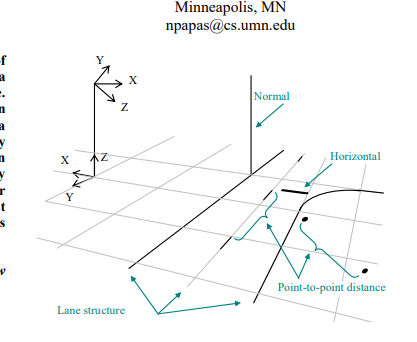

# Класс модели

In [277]:
class Model:
  def __init__(self):
    self.coord_image = []
    self.coord_real = []

  def line_struct(self):
    pass

  def point_to_point(self):
    pass

  def normal(self):
    pass

# Класс точки

In [278]:
class Point:
    def __init__(self, x, y, X, Y, Z):
        self.x = x
        self.y = y
        self.X = X
        self.Y = Y
        self.Z = Z
        self.w = 1
        
    def set_w(self, w):
        self.w = w
        
    def get_real(self):
        return np.array([self.X/self.w, self.Y/self.w, self.Z/self.w])
    
    def get_real_full(self):
        return np.array([self.X, self.Y, self.Z, self.w])
    
    def get_image(self):
        return np.array([self.x/self.w, self.y/self.w])
    
    def get_image_full(self):
        return np.array([self.x, self.y, self.w])
    

# Класс камеры

In [279]:
class Camera:
  def __init__(self):
    self.size = None
    self.image = None
    self.tau = None
    
    self.A = np.zeros((3,3))
    self.R = np.zeros((3,3))
    self.T = np.zeros((3,1)).reshape(-1,1)

  
  def get_tau(self):
    return self.tau

  def load_image(self, path):
    self.image = cv2.imread(path)
    height, width, channels = self.image.shape
    self.size = [height, width] # высота и ширина
    self.tau = height / width

  # вычисление матрицы поворота
  def calc_R(self, euler_angles):
    rot = Rotation.from_euler('xyz', euler_angles, degrees=True)
    self.R = rot.as_matrix()

  def update_R(self, px, py, pz):
    self.R =  np.vstack([px, py, pz]).transpose()
  
  def get_R(self):
    return self.R
  
  # вычисление столбца переноса
  def calc_T(self, h):
    self.T = np.array([0, 0, h]).reshape(-1,1)
    
  def get_T(self):
    return self.T
  
  # вычисление внутренней матрицы
  def calc_A(self, f):
    self.A = np.array([[f, 0, 0],
                     [0, f, 0],
                     [0, 0, 1]])
    
  # вычисление внутренней матрицы уточняющий способ 
  def calc_A_v2(self, f):
    self.A = np.array([[f, 0, 0],
                     [0, f * self.tau, 0],
                     [0, 0, 1]])
    
  def get_A(self):
    return self.A

 # прямое преобразование
  def direct_transform(self, point_real:Point):
    
    T = self.T.reshape(-1, 1) 
    RT = np.hstack([self.R, self.T])
    AT = self.A @ RT
    return AT @ point_real.get_real_full()
  
  # обратное преобразование
  def back_transform(self, point_image:Point):
    
    T = self.T.reshape(-1, 1) 
    RT = np.hstack([self.R, self.T])
    AT_inv = np.linalg.inv(self.A @ RT)
    return AT_inv @ point_image.get_image_full()

# Класс оптимизатора

In [280]:
class Optimizer:
  def __init__(self, model: Model, camera: Camera):
    self.model = model
    self.camera = camera

  def optimize(self):
      pass

# Начальное решение

In [281]:
class InitSolution:
    def __init__(self):
        self.f = None
        self.v = [] # x, y, z
        self.p = [] # x, y, z
        
    def get_f(self):
        return self.f
    
    def get_p(self):
        return self.p
    
    def get_v(self ):
        return self.v
    
        
    def _normal_vector(self,x1, y1, x2, y2):
        dx = x2 - x1
        dy = y2 - y1

        normal = np.array([-dy, dx]) / np.sqrt(dx * dx + dy * dy)
        return normal

    # поиск точек схода
    def search_vanishing_point(self, L):
        A = []
        b = []

        for line in L:
            (x1, y1), (x2, y2) = line

            n = self._normal_vector(x1, y1, x2, y2)

            A.append(n)

            b.append(np.dot(n, [x1, y1]))

        A = np.array(A)
        b = np.array(b)


        v = np.linalg.lstsq(A, b, rcond=None)[0]
        self.v.append(v)
        
    # вычисление нормализованный точек схода    
    def calc_norm_vanishing_point(self, camera):
        px = np.linalg.inv(camera.get_A().transpose()) @ np.transpose(np.hstack([self.v[0], 1]))
        py = np.linalg.inv(camera.get_A().transpose()) @ np.transpose(np.hstack([self.v[1], 1]))
        pz = px * py
        self.p = [px, py, pz]

    # вычисление фокусного расстояния
    def calc_f(self, D = np.array([0, 0])):
        if len(self.v)==2:
            self.f = np.sqrt(-np.dot((self.v[0] - D), (self.v[1] - D)))

    def calc_f_v2(self, camera):
        if len(self.v) == 2:
            M = np.array([[1, 0], [0, camera.tau**(-2)]])
            self.f = np.sqrt(- self.v[0].T @ M @ self.v[1])

Line_Y = [[[786, 689], [281, 515]], [[1061, 516], [213, 340]], [[1008, 421], [375, 311]], [[355, 264], [70, 238]], [[362, 223], [73, 211]]]
Line_X = [[[300, 513], [555, 185]], [[835, 677], [927, 264]], [[674, 117], [740, 13]], [[833, 192], [842, 158]], [[954, 142], [954, 38]]]

init = InitSolution()
init.search_vanishing_point(Line_X)
init.search_vanishing_point(Line_Y)

# Первый вариант

In [292]:
camera = Camera()
camera.load_image('../data/scene_from_crossroads_not_dist.png')

init.calc_f_v2(camera)
camera.calc_A(init.get_f())
init.calc_norm_vanishing_point(camera)



In [283]:
lines = [
    [[831, 689, 7.71, 0, 0], 
    [299, 520, 7.71, 20.7, 0]],
    [[1007, 425, 18.9, 0, 0],
    [439, 322, 18.9, 20.7, 0]],
    [[927, 267, 31.9, 0, 0],
    [553, 189, 31.9, 20.7, 0]]
]

lines_struct = []

for line in lines:
    line_start, line_end = line
    point_start = Point(line_start[0],line_start[1],line_start[2],line_start[3],line_start[4])
    point_end = Point(line_end[0],line_end[1],line_end[2],line_end[3],line_end[4])
    
    lines_struct.append([point_start,point_end])

In [284]:
def funk_error(line_known:Point,line_predict:Point):
    pointknownStart, pointknownEnd = line_known
    pointpredictStart, pointpredictEnd = line_predict
    
    error = np.sqrt((pointknownStart.get_image()[0] - pointpredictStart.get_image()[0])**2 + (pointknownStart.get_image()[1] - pointpredictStart.get_image()[1])**2) 
    + np.sqrt((pointknownEnd.get_image()[0] - pointpredictEnd.get_image()[0])**2 + (pointknownEnd.get_image()[1] - pointpredictEnd.get_image()[1])**2)
    
    return error

# Второй вариант

In [285]:

f = calc_f(vx, vy)
camera.calc_A(f)
print(f'Фокус: {f}')
px = np.linalg.inv(camera.get_A().transpose()) @ np.transpose(np.hstack([vx, 1]))
py = np.linalg.inv(camera.get_A().transpose()) @ np.transpose(np.hstack([vy, 1]))
pz = px * py
print(f'Точки схода нормализованные: {px, py, pz}')

Фокус: 859.0848540375282
Точки схода нормализованные: (array([ 1.15661478, -0.42372319,  1.        ]), array([-0.79535188,  0.18900137,  1.        ]), array([-0.91991574, -0.08008426,  1.        ]))


In [286]:
camera.update_R(px, py, pz)
camera.calc_T(1)
camera.get_R()

array([[ 1.15661478, -0.79535188, -0.91991574],
       [-0.42372319,  0.18900137, -0.08008426],
       [ 1.        ,  1.        ,  1.        ]])

In [287]:
R = camera.get_R()  # Матрица (3, 3)
T = camera.get_T()  # Вектор (3,) или (3, 1)

T = T.reshape(-1, 1)  # Теперь T имеет размерность (3, 1)

RT = np.hstack([R, T])

AT = camera.get_A() @ RT
print(f"Объединенная матрица RT: \n{AT}")
r = Rotation.from_matrix(R)
angles = r.as_euler("zyx",degrees=True)
print(f'Начальные углы для матрицы поворота {angles}')

Объединенная матрица RT: 
[[ 993.63023609 -683.27475384 -790.28567642    0.        ]
 [-364.01417769  162.3682128   -68.79917762    0.        ]
 [   1.            1.            1.            1.        ]]
Начальные углы для матрицы поворота [ 37.85506188 -48.08912174  53.1808465 ]
